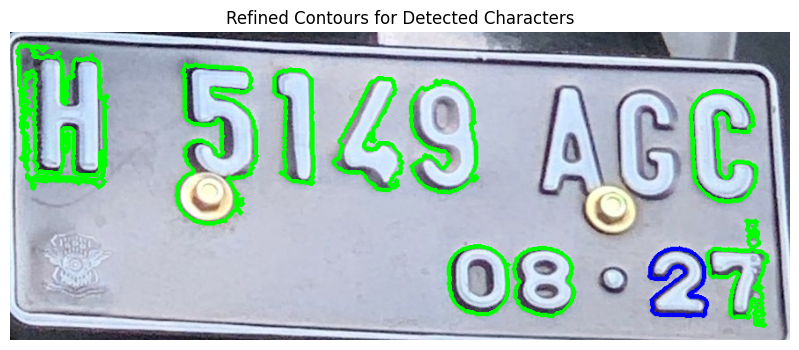

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load the image from the provided path
img = cv2.imread('./cropped_15.jpg')

# Check if the image was loaded correctly
if img is None:
    print("Error: Image not found.")
else:
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    blur = cv2.GaussianBlur(gray, (5, 5), 0)

    # Adaptive thresholding to get a binary image
    adaptive_thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                            cv2.THRESH_BINARY_INV, 11, 2)

    # Morphological operations to clean up the image
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    morph = cv2.morphologyEx(adaptive_thresh, cv2.MORPH_CLOSE, kernel)

    # Find contours
    contours, _ = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Contour filtering based on properties
    filtered_contours = []
    for contour in contours:
        area = cv2.contourArea(contour)
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = w / float(h)
        solidity = area / (w * h)
        # Filter based on area, aspect ratio, and solidity to target more rectangular and solid shapes
        if area > 50 and 0.2 < aspect_ratio < 1.0 and solidity > 0.4:
            filtered_contours.append(contour)

    # Attempt to isolate the 'H' by looking for contours that are wider than they are tall
    h_contour = None
    for contour in filtered_contours:
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = w / float(h)
        if aspect_ratio > 0.8:  # Looking for a contour that is wider, which might be 'H'
            h_contour = contour
            break

    # Draw contours on the image
    img_contours_filtered = img.copy()
    cv2.drawContours(img_contours_filtered, filtered_contours, -1, (0, 255, 0), 3)
    if h_contour is not None:
        cv2.drawContours(img_contours_filtered, [h_contour], -1, (255, 0, 0), 3)

    # Display the result
    plt.figure(figsize=(12, 4))
    plt.imshow(cv2.cvtColor(img_contours_filtered, cv2.COLOR_BGR2RGB))
    plt.title('Refined Contours for Detected Characters')
    plt.axis('off')
    plt.show()


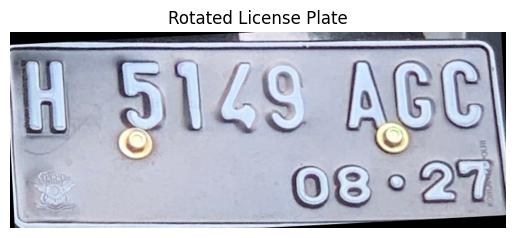

Rotated Plate Number: Pe lce Bee



In [1]:
import cv2
import numpy as np
import pytesseract
from matplotlib import pyplot as plt

def rotate_image(img, angle):
    (h, w) = img.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(img, M, (w, h))
    return rotated

def recognize_license_plate(plate_image):
    gray_plate = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)
    # Apply some additional processing here if needed like thresholding
    return pytesseract.image_to_string(gray_plate, config='--psm 7 --oem 3')

# Load the image from the uploaded path
image_path = './cropped_15.jpg'
plate_image = cv2.imread(image_path)

if plate_image is None:
    print("Image not found or unable to read.")
else:
    # Assuming the plate might need rotation correction
    gray_plate = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray_plate, 50, 150, apertureSize=3)
    lines = cv2.HoughLines(edges, 1, np.pi / 180, threshold=100)

    if lines is not None:
        for line in lines:
            rho, theta = line[0]
            if np.degrees(theta) > 45:
                angle = np.degrees(theta) - 90
                rotated_plate = rotate_image(plate_image, angle)
                # Assuming you want to display the rotated plate using matplotlib
                plt.imshow(cv2.cvtColor(rotated_plate, cv2.COLOR_BGR2RGB))
                plt.title('Rotated License Plate')
                plt.axis('off')
                plt.show()

                plate_text = recognize_license_plate(rotated_plate)
                print("Rotated Plate Number:", plate_text)
                break
    else:
        # Assuming you want to display the plate using matplotlib
        plt.imshow(cv2.cvtColor(plate_image, cv2.COLOR_BGR2RGB))
        plt.title('License Plate')
        plt.axis('off')
        plt.show()
        plate_text = recognize_license_plate(plate_image)
        print("Plate Number:", plate_text)


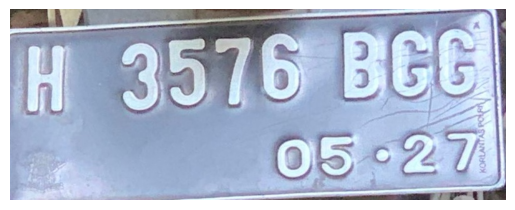

Detected text: OO



In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = './cropped_13.jpg'
image = cv2.imread(image_path)

# Convert the image to gray scale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Use a threshold to create a binary image
_, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)

# Find contours
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Function to check if a contour is likely to be a character
def is_character_contour(contour, img):
    # Get contour bounding box
    x, y, w, h = cv2.boundingRect(contour)
    
    # Check if the contour is within the expected character size range
    aspect_ratio = w / float(h)
    area = cv2.contourArea(contour)
    char_area = img.shape[0] * img.shape[1] / 35  # estimate character area based on image size
    return (aspect_ratio > 0.2 and aspect_ratio < 1.0 and
            h > img.shape[0] / 10 and h < img.shape[0] / 2 and
            area > char_area / 15 and area < char_area)

# Filter out contours that are not characters
char_contours = [c for c in contours if is_character_contour(c, image)]

# Create a clean mask where we will draw the characters
clean_mask = np.zeros_like(gray)

# Draw the character contours on the mask
cv2.drawContours(clean_mask, char_contours, -1, (255), thickness=cv2.FILLED)

# Apply the mask to get a clean image of the text
clean_image = cv2.bitwise_and(image, image, mask=clean_mask)

# Invert the mask
inverted_mask = cv2.bitwise_not(clean_mask)

# Apply the inverted mask to get a clean image of the text with a white background
inverted_image = cv2.bitwise_and(image, image, mask=inverted_mask)

# Fill the area outside the text with white color
outside_text = cv2.bitwise_not(inverted_mask)
filled_image = cv2.cvtColor(outside_text, cv2.COLOR_GRAY2BGR) + inverted_image

# Display the final inverted image with a white background
plt.imshow(cv2.cvtColor(filled_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

import pytesseract

# If pytesseract is not in the PATH, include the following:
# pytesseract.pytesseract.tesseract_cmd = r'<full_path_to_your_tesseract_executable>'

# Read the text from the inverted mask
text = pytesseract.image_to_string(inverted_mask, config='--psm 7')

print("Detected text:", text)



Detected text using Pytesseract: HSL ACE
Detected text: HSL with confidence: 61
Detected text: ACE with confidence: 74


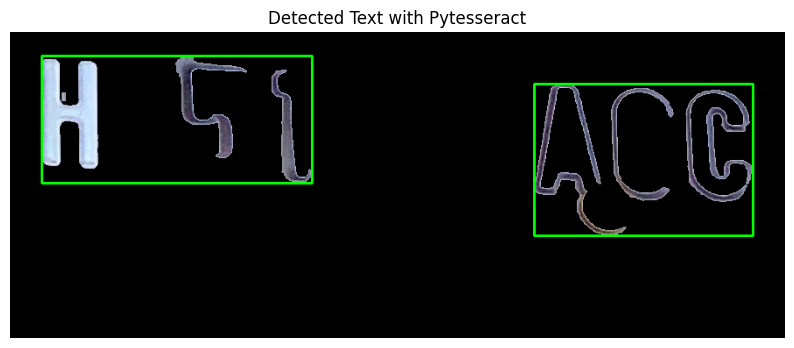

In [3]:
# Import necessary libraries
import cv2
import numpy as np
from matplotlib import pyplot as plt
import easyocr
import pytesseract


# Load the image
image_path = './cropped_15.jpg'
img = cv2.imread(image_path)

# Ensure the image is loaded
if img is None:
    print(f"Image at {image_path} could not be read.")
else:
    # Convert to grayscale and apply preprocessing
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    normalized_gray = cv2.normalize(gray, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    _, img_plate_bw = cv2.threshold(normalized_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    img_plate_bw = cv2.morphologyEx(img_plate_bw, cv2.MORPH_OPEN, kernel, iterations=2)

    # Find contours and filter them
    contours, _ = cv2.findContours(img_plate_bw, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    filtered_contours = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if area < 100: continue
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = float(w) / h
        if 0.2 < aspect_ratio < 1.0 and gray.shape[0] * 0.3 < h < gray.shape[0] * 0.8 and gray.shape[1] * 0.02 < w < gray.shape[1] * 0.15:
            filtered_contours.append(contour)

    # Create a blank mask that matches the image size
    mask = np.zeros_like(img)

    # Draw the filtered contours on the mask with white color and full opacity
    cv2.drawContours(mask, filtered_contours, -1, (255, 255, 255), thickness=cv2.FILLED)

    # Apply the mask to the original image
    img_masked = cv2.bitwise_and(img, mask)

    # Convert the masked image to RGB for EasyOCR
    img_rgb = cv2.cvtColor(img_masked, cv2.COLOR_BGR2RGB)

import pytesseract

# Specify the path to the Tesseract executable if it's not in the system PATH
# pytesseract.pytesseract.tesseract_cmd = r'C:\path\to\tesseract.exe'  # Uncomment this line if needed

# Perform OCR using pytesseract on the masked image
custom_config = r'--oem 3 --psm 6'
pytesseract_text = pytesseract.image_to_string(img_rgb, config=custom_config)

# Print the detected text from pytesseract
print(f"Detected text using Pytesseract: {pytesseract_text.strip()}")

# Optionally, you can get the detailed information about boxes, confidences, and text
data = pytesseract.image_to_data(img_rgb, output_type=pytesseract.Output.DICT, config=custom_config)

# Iterate over each text localization box and draw them on the image
n_boxes = len(data['level'])
for i in range(n_boxes):
    if int(data['conf'][i]) > 0:  # Confidence threshold, if necessary
        (x, y, w, h) = (data['left'][i], data['top'][i], data['width'][i], data['height'][i])
        img_rgb = cv2.rectangle(img_rgb, (x, y), (x + w, y + h), (0, 255, 0), 2)
        print(f"Detected text: {data['text'][i]} with confidence: {data['conf'][i]}")

# Display the image with bounding boxes
plt.figure(figsize=(10, 5))
plt.imshow(img_rgb)
plt.title('Detected Text with Pytesseract')
plt.axis('off')
plt.show()


Detected text: K 2337 with confidence: 0.5051081690703733
Detected text: DAA with confidence: 0.9531978664625973
Detected text: 10. 2 7 with confidence: 0.5428988189844537
Combined detected text: K 2337 DAA 10. 2 7


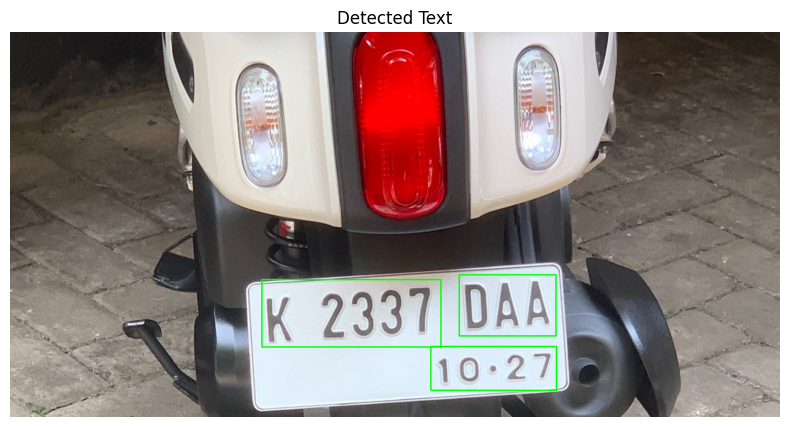

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import easyocr

# Load the image
image_path = '../WhatsApp Image 2024-02-29 at 10.45.49_f4532537.jpg'  # Update to your image path
img = cv2.imread(image_path)

# Ensure the image is loaded
if img is None:
    print(f"Image at {image_path} could not be read.")
else:
    # Assuming the top plate is within the top 1/3rd of the image.
    # You might need to adjust these coordinates based on the actual image.
    h, w, _ = img.shape
    top_plate_region = img[0:int(h/1.5), 0:w]

    # Convert to grayscale
    gray = cv2.cvtColor(top_plate_region, cv2.COLOR_BGR2GRAY)

    # Create a reader instance for EasyOCR
    reader = easyocr.Reader(['en'])

    # Use the reader to detect text from the grayscale image
    results = reader.readtext(gray)

    # Convert the cropped top plate region to RGB for visualization
    top_plate_region_rgb = cv2.cvtColor(top_plate_region, cv2.COLOR_BGR2RGB)

    # Print and draw detected text
    for (bbox, text, prob) in results:
        print(f"Detected text: {text} with confidence: {prob}")
        top_left = tuple([int(val) for val in bbox[0]])
        bottom_right = tuple([int(val) for val in bbox[2]])
        top_plate_region_rgb = cv2.rectangle(top_plate_region_rgb, top_left, bottom_right, (0, 255, 0), 2)

    # Combine detected text
    combined_text = " ".join([text for (_, text, _) in results]).strip()
    print(f"Combined detected text: {combined_text}")

    # Display the image with bounding boxes
    plt.figure(figsize=(10, 5))
    plt.imshow(top_plate_region_rgb)
    plt.title('Detected Text')
    plt.axis('off')
    plt.show()
